<a href="https://colab.research.google.com/github/rohan-vr/Natural-Language-Processing/blob/master/Eng_Hin_NMT_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import all the necessary modules

In [0]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dropout
from keras.layers import Dense, Bidirectional
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop

Now comes the part of loading our cleaned English and Hindi datasets and create tokenizer for English dataset and Hindi dataset and then we find the max length of sentences of English and Hindi. At last we encode sequences to prepare training data and validation data.

In [34]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# load datasets
dataset = load_clean_sentences('en-hi-both.pkl')
train = load_clean_sentences('en-hi-train.pkl')
test = load_clean_sentences('en-hi-test.pkl')

# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

# prepare german tokenizer
hin_tokenizer = create_tokenizer(dataset[:, 1])
hin_vocab_size = len(hin_tokenizer.word_index) + 1
hin_length = max_length(dataset[:, 1])
print('Hindi Vocabulary Size: %d' % hin_vocab_size)
print('Hindi Max Length: %d' % (hin_length))

# prepare training data
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_sequences(hin_tokenizer, hin_length, train[:, 1])

# prepare validation data
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_sequences(hin_tokenizer, hin_length, test[:, 1])

English Vocabulary Size: 36441
English Max Length: 15
Hindi Vocabulary Size: 49562
Hindi Max Length: 17


Now comes the part to define our model. Lets do it!

In [24]:
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(Bidirectional(LSTM(units=n_units)))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(Dense(tar_vocab, activation='softmax'))
	return model

model = define_model(eng_vocab_size, hin_vocab_size, eng_length, hin_length, 512)
rms = RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 15, 512)           18657792  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 1024)              4198400   
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 17, 1024)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 17, 512)           3147776   
_________________________________________________________________
dense_5 (Dense)              (None, 17, 49562)         25425306  
Total params: 51,429,274
Trainable params: 51,429,274
Non-trainable params: 0
_________________________________________________________________
None


Now let us save the model. Dont forget to save checkpoints.

In [0]:
filename = 'model.h1.24_april_20'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Now let us train the model and keep a track of loss and validation loss which will help us to plot these two variables in a graph so we can visualize it easily.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 216000 samples, validate on 24000 samples
Epoch 1/30
216000/216000 [==============================] - 267s 1ms/step - loss: 2.4804 - val_loss: 2.1540

Epoch 00001: val_loss improved from inf to 2.15399, saving model to model.h1.24_april_20
Epoch 2/30
216000/216000 [==============================] - 265s 1ms/step - loss: 2.0001 - val_loss: 1.8702

Epoch 00002: val_loss improved from 2.15399 to 1.87024, saving model to model.h1.24_april_20
Epoch 3/30
216000/216000 [==============================] - 264s 1ms/step - loss: 1.7322 - val_loss: 1.6587

Epoch 00003: val_loss improved from 1.87024 to 1.65871, saving model to model.h1.24_april_20
Epoch 4/30
216000/216000 [==============================] - 265s 1ms/step - loss: 1.5301 - val_loss: 1.5019

Epoch 00004: val_loss improved from 1.65871 to 1.50188, saving model to model.h1.24_april_20
Epoch 5/30
216000/216000 [==============================] - 265s 1ms/step - loss: 1.3713 - val_loss: 1.3912

Epoch 00005: val_loss improved from 

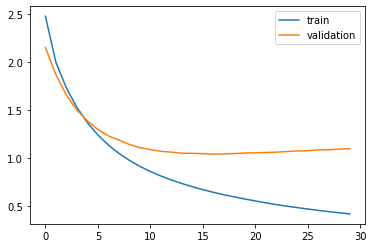

In [26]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), epochs=30, batch_size=512, validation_split=0.1, callbacks=[checkpoint],  verbose=1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Okay so now we are done with training. As we can see the graph, that is a pretty smooth curve! Now is the time to test our model. First we will load the model then make predictions over the test dataset we created.

In [36]:
from keras.models import load_model

testX=testX[0:100] # lets take 50 sentences of test data set

model = load_model('model.h1.24_april_20')

preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

# a function that is going to grab words.
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], hin_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], hin_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Okay so now time to visualize predictions.

In [46]:
import pandas as pd
pred_df = pd.DataFrame({'input' : test[0:50,0], 'actual' : test[0:50,1], 'predicted' : preds_text})
pred_df.sample(15)

,input,actual,predicted
46,custom location,पसंदीदा स्थानः,अनुकूलित स्थान
7,if it snows tomorrow i ll build a snowman,अगर कल बर्फ़ गिरी तो मैं स्नोमैन बनाऊंगा।,अगर कल तो
42,close the current archive,वर्तमान अभिलेख बन्द करें,वर्तमान अभिलेख बन्द करें
25,paragraph background set,पैराग्राफ पृष्ठभूमि सेट,पृष्ठभूमि
17,select a disc to write to,डिस्क चुनें जिसमें लिखना है,डिस्क चुनें जिसमें लिखना है
44,krecipes exported recipes,केरेसिपि निर्यात किए गए रेसिपि,परवरदिगार निर्दिष्ट कॉन्फ़िगर
34,member,सदस्य,सदस्य
37,this which we recite unto thee is of the signs...,ये आयतें है और हिकमत तत्वज्ञान से परिपूर्ण अनु...,ये आयतें है और हिकमत तत्वज्ञान से परिपूर्ण अनु...
0,choosing books help is at hand,किताबें चुननासहायता समीप ही उपलब्ध है।,यहां के हैं
11,and restrain their carnal desires,और जो अपने गुप्तांगों की रक्षा करते है,और जो अपनी शर्मगाहों को हराम को बचाते


Okay so now we got some satisfying results. That is it. We are done with translation.